<a href="https://colab.research.google.com/github/kochlisGit/Physics-Informed-Neural-Network-PINN-/blob/main/TF_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow v2** will be used to train a *Physics-Informed Neural Network* (*PINN*) model. The model will be trained to solve the equation $\frac{dy}{dx} = y$ with $y(0) = 1$ for interval $x \in [0, 2]$ . We know that the solution of this equation is $y=e^x.$ 




In [ ]:
import tensorflow as tf

We are now going to generate some points in the interval $[0, 2]$. This function could also be used to generate rectanges and hyperplanes as well (e.g. `generate_uniform_data(num_domain=100, minval=[0,0], maxval=[1,1])`)

In [ ]:
num_domain = 32
minval = 0
maxval = 2

def generate_uniform_data(num_domain, minval, maxval):
  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

x = generate_uniform_data(num_domain, minval, maxval)
x

<tf.Variable 'Variable:0' shape=(32, 1) dtype=float32, numpy=
array([[0.42203093],
       [1.41202   ],
       [1.6001267 ],
       [1.5415845 ],
       [0.77717733],
       [1.7407188 ],
       [1.616375  ],
       [0.3938818 ],
       [1.6985414 ],
       [1.0803521 ],
       [0.27217007],
       [0.22239375],
       [1.4941943 ],
       [0.39473152],
       [0.71548843],
       [1.0405965 ],
       [0.8522768 ],
       [0.42251015],
       [0.43519688],
       [0.31763887],
       [0.3279183 ],
       [1.9947593 ],
       [0.82617426],
       [0.40056705],
       [1.4406891 ],
       [0.14499807],
       [0.56532216],
       [0.383291  ],
       [0.09421492],
       [1.3626337 ],
       [0.3398428 ],
       [0.82003   ]], dtype=float32)>

In order to compute the error of our neural network, we are going to have to compute the derivative of $y$ with respect to $x$. The coolest part about neural networks is that this can easily be done via **Back-Propagation**. In Tensorflow, this can be done via the *gradient* method of a *GradientTape*.

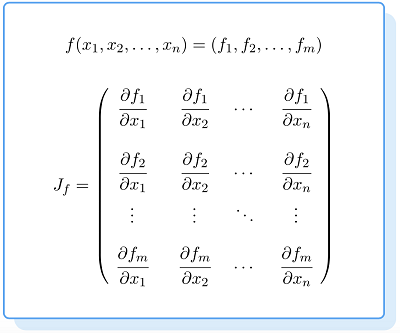

In [ ]:
def jacobian(tape, y, x, i=0, j=0):
  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  grads = tape.gradient(y, x)
  return grads[:, j : j + 1]

def pde(tape, x, y):
  dy_x = jacobian(tape, y, x)
  return dy_x - y

def ic_0(x):
  return 1

x_ic = tf.constant(0, shape=[1,1])

Building the model. Our model will be a Fully Connected Neural Network (FC Net) with `[32, 32]` hidden units and 1 output unit. The output of each hidden unit will be passed through a `tanh` activation. The output layer will not use any activation function.

In [ ]:
n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=32, activation=activation))
model.add(tf.keras.layers.Dense(units=32, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 5000
learning_rate = 0.0005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for i in range(epochs + 1):
  with tf.GradientTape() as tape_model:
    with tf.GradientTape() as tape_pde:
      y = model(x, training=True)
      ic_error = model(x_ic, training=True)[0][0] - ic_0(x_ic)
      domain_error = pde(tape_pde, x, y)

    domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
    ic_mse =  tf.math.square(ic_error)
    total_mse = domain_mse + ic_mse

    if i % 1000 == 0:
      print('Epoch: {}\t MSE Loss = {}'.format(i, total_mse.numpy()[0]))

  model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )



Epoch: 0	 MSE Loss = 1.0044512748718262
Epoch: 1000	 MSE Loss = 0.022879835218191147
Epoch: 2000	 MSE Loss = 0.0030162064358592033
Epoch: 3000	 MSE Loss = 0.0006103964988142252
Epoch: 4000	 MSE Loss = 0.00026747395168058574
Epoch: 5000	 MSE Loss = 0.00016321982548106462


Evaluating our model. For the evaluation part, we will create a random uniform points inside the domain $[0, 2]$ and test our model.

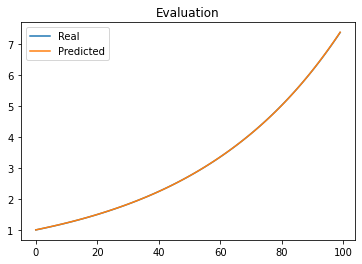

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_test = np.linspace(0, 2, 100)
y_true = np.exp(x_test)
y_pred = model(x_test)

plt.plot(y_true)
plt.plot(y_pred)
plt.title('Evaluation')
plt.legend(['Real', 'Predicted'])
plt.show()